# Formula 1 - Predicting the winner of a race

In this notebook we will benchmark getML against featuretools to predict the winner of a Formula 1 race.

Summary:

- Prediction type: __Classification model__
- Domain: __Sports__
- Prediction target: __Win__ 
- Population size: __31578__

## Background

We would like to develop a prediction model for Formula 1 races, that would allow us to predict the winner of a race before the race has started.

We use dataset of all Formula 1 races from 1950 to 2017. The dataset includes information such as the time taken in each lap, the time taken for pit stops, the performance in the qualifying rounds etc.

The dataset has been downloaded from the [CTU Prague relational learning repository](https://relational.fit.cvut.cz/dataset/ErgastF1) (Motl and Schulte, 2015) (Now residing at [relational-data.org](https://relational-data.org/dataset/ErgastF1).).

We will benchmark [getML](https://www.getml.com)'s feature learning algorithms against [featuretools](https://www.featuretools.com), an open-source implementation of the propositionalization algorithm, similar to getML's FastProp.

## Analysis

In [ ]:
!pip install -q "getml==1.5.0" "matplotlib==3.9.2" "featuretools==1.31.0" 
!export GETML_SHOW_IPYWIDGETS_WARNING="f" 

Let's get started with the analysis and set up your session:

In [296]:

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
from pathlib import Path
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

import featuretools
import woodwork as ww
import getml

getml.engine.launch(home_directory=Path.home(), allow_remote_ips=True, token='token')
getml.engine.set_project('formula1')

Launching ./getML --allow-push-notifications=true --allow-remote-ips=true --home-directory=/home/getml --in-memory=true --install=false --launch-browser=true --log=false --token=token in /home/getml/.getML/getml-1.5.0-x64-linux...
Launched the getML Engine. The log output will be stored in /home/getml/.getML/logs/20240906095726.log.
  Loading pipelines... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:005m 75% • 00:01


Connected to project 'formula1'

### 1. Loading data

#### 1.1 Download from source

We begin by downloading the data:

In [240]:
conn = getml.database.connect_mysql(
    host="db.relational-data.org",
    dbname="ErgastF1",
    port=3306,
    user="guest",
    password="relational"
)

conn

Connection(dbname='ErgastF1',
           dialect='mysql',
           host='db.relational-data.org',
           port=3306)

In [241]:
def load_if_needed(name):
    """
    Loads the data from the relational learning
    repository, if the data frame has not already
    been loaded.
    """
    if not getml.data.exists(name):
        data_frame = getml.data.DataFrame.from_db(
            name=name,
            table_name=name,
            conn=conn
        )
        data_frame.save()
    else:
        data_frame = getml.data.load_data_frame(name)
    return data_frame

In [242]:
driverStandings = load_if_needed("driverStandings")
drivers = load_if_needed("drivers")
lapTimes = load_if_needed("lapTimes")
pitStops = load_if_needed("pitStops")
races = load_if_needed("races")
qualifying = load_if_needed("qualifying")

In [243]:
driverStandings

name,driverStandingsId,raceId,driverId,points,position,wins,positionText
role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string
0,1,18,1,10,1,1,1
1,2,18,2,8,2,0,2
2,3,18,3,6,3,0,3
3,4,18,4,5,4,0,4
4,5,18,5,4,5,0,5
,...,...,...,...,...,...,...
31573,68456,982,835,8,16,0,16
31574,68457,982,154,26,13,0,13
31575,68458,982,836,5,18,0,18


In [244]:
drivers

name,driverId,number,driverRef,code,forename,surname,dob,nationality,url
role,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
0,1,44,hamilton,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lew...
1,2,nan,heidfeld,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nic...
2,3,6,rosberg,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nic...
3,4,14,alonso,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fer...
4,5,nan,kovalainen,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Hei...
,...,...,...,...,...,...,...,...,...
835,837,88,haryanto,HAR,Rio,Haryanto,1993-01-22,Indonesian,http://en.wikipedia.org/wiki/Rio...
836,838,2,vandoorne,VAN,Stoffel,Vandoorne,1992-03-26,Belgian,http://en.wikipedia.org/wiki/Sto...
837,839,31,ocon,OCO,Esteban,Ocon,1996-09-17,French,http://en.wikipedia.org/wiki/Est...


In [245]:
lapTimes

name,raceId,driverId,lap,position,milliseconds,time
role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string
0,1,1,1,13,109088,1:49.088
1,1,1,2,12,93740,1:33.740
2,1,1,3,11,91600,1:31.600
3,1,1,4,10,91067,1:31.067
4,1,1,5,10,92129,1:32.129
,...,...,...,...,...,...
420364,982,840,54,8,107528,1:47.528
420365,982,840,55,8,107512,1:47.512
420366,982,840,56,8,108143,1:48.143


In [246]:
pitStops

name,raceId,driverId,stop,lap,milliseconds,time,duration
role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string
0,841,1,1,16,23227,17:28:24,23.227
1,841,1,2,36,23199,17:59:29,23.199
2,841,2,1,15,22994,17:27:41,22.994
3,841,2,2,30,25098,17:51:32,25.098
4,841,3,1,16,23716,17:29:00,23.716
,...,...,...,...,...,...,...
6065,982,839,6,38,29134,21:29:07,29.134
6066,982,840,1,1,37403,20:06:43,37.403
6067,982,840,2,2,29294,20:10:07,29.294


In [247]:
races

name,raceId,year,round,circuitId,name,date,time,url
role,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/200...
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/200...
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/200...
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/200...
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/200...
,...,...,...,...,...,...,...,...
971,984,2017,16,22,Japanese Grand Prix,2017-10-08,05:00:00,https://en.wikipedia.org/wiki/20...
972,985,2017,17,69,United States Grand Prix,2017-10-22,19:00:00,https://en.wikipedia.org/wiki/20...
973,986,2017,18,32,Mexican Grand Prix,2017-10-29,19:00:00,https://en.wikipedia.org/wiki/20...


In [248]:
qualifying

name,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079
3,4,18,13,6,2,4,1:25.994,1:25.691,1:27.178
4,5,18,2,2,3,5,1:25.960,1:25.518,1:27.236
,...,...,...,...,...,...,...,...,...
7392,7415,982,825,210,20,16,1:43.756,NULL,NULL
7393,7416,982,13,3,19,17,1:44.014,NULL,NULL
7394,7417,982,840,3,18,18,1:44.728,NULL,NULL


#### 1.2 Prepare data for getML

In [249]:
racesPd = races.to_pandas()
racesPd

,raceId,year,round,circuitId,name,date,time,url
0,1.0,2009.0,1.0,1.0,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...
1,2.0,2009.0,2.0,2.0,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...
2,3.0,2009.0,3.0,17.0,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...
3,4.0,2009.0,4.0,3.0,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...
4,5.0,2009.0,5.0,4.0,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...
...,...,...,...,...,...,...,...,...
971,984.0,2017.0,16.0,22.0,Japanese Grand Prix,2017-10-08,05:00:00,https://en.wikipedia.org/wiki/2017_Japanese_Gr...
972,985.0,2017.0,17.0,69.0,United States Grand Prix,2017-10-22,19:00:00,https://en.wikipedia.org/wiki/2017_United_Stat...
973,986.0,2017.0,18.0,32.0,Mexican Grand Prix,2017-10-29,19:00:00,https://en.wikipedia.org/wiki/2017_Mexican_Gra...
974,987.0,2017.0,19.0,18.0,Brazilian Grand Prix,2017-11-12,16:00:00,https://en.wikipedia.org/wiki/2017_Brazilian_G...


We actually need some set-up, because the target variable is not readily available. The `wins` column in `driverStandings` is actually the accumulated number of wins over a year, but what we want is a boolean variable indicated whether someone has one a particular race or not.

In [250]:
driverStandingsPd = driverStandings.to_pandas()

driverStandingsPd = driverStandingsPd.merge(
    racesPd[["raceId", "year", "date", "round"]],
    on="raceId"
)

previousStanding = driverStandingsPd.merge(
    driverStandingsPd[["driverId", "year", "wins", "round"]],
    on=["driverId", "year"],
)

isPreviousRound = (previousStanding["round_x"] - previousStanding["round_y"] == 1.0)

previousStanding = previousStanding[isPreviousRound]

previousStanding["win"] = previousStanding["wins_x"] - previousStanding["wins_y"]

driverStandingsPd = driverStandingsPd.merge(
    previousStanding[["raceId", "driverId", "win"]],
    on=["raceId", "driverId"],
    how="left",
)

driverStandingsPd["win"] = [win if win == win else wins for win, wins in zip(driverStandingsPd["win"], driverStandingsPd["wins"])]

driver_standings = getml.data.DataFrame.from_pandas(driverStandingsPd, "driver_standings")

driver_standings

name,driverStandingsId,raceId,driverId,points,position,wins,year,round,win,positionText,date
role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string
0,1,18,1,10,1,1,2008,1,1,1,2008-03-16
1,2,18,2,8,2,0,2008,1,0,2,2008-03-16
2,3,18,3,6,3,0,2008,1,0,3,2008-03-16
3,4,18,4,5,4,0,2008,1,0,4,2008-03-16
4,5,18,5,4,5,0,2008,1,0,5,2008-03-16
,...,...,...,...,...,...,...,...,...,...,...
31573,68456,982,835,8,16,0,2017,14,0,16,2017-09-17
31574,68457,982,154,26,13,0,2017,14,0,13,2017-09-17
31575,68458,982,836,5,18,0,2017,14,0,18,2017-09-17


We also need to include the date of the race to `lapTimes` and `pitStops`, because we cannot use this data for the race we would like to predict. We can only take lap times and pit stops from previous races.

In [251]:
lapTimesPd = lapTimes.to_pandas()

lapTimesPd = lapTimesPd.merge(
    racesPd[["raceId", "date", "year"]],
    on="raceId"
)

lap_times = getml.data.DataFrame.from_pandas(lapTimesPd, "lap_times")

lap_times

name,raceId,driverId,lap,position,milliseconds,year,time,date
role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string
0,1,1,1,13,109088,2009,1:49.088,2009-03-29
1,1,1,2,12,93740,2009,1:33.740,2009-03-29
2,1,1,3,11,91600,2009,1:31.600,2009-03-29
3,1,1,4,10,91067,2009,1:31.067,2009-03-29
4,1,1,5,10,92129,2009,1:32.129,2009-03-29
,...,...,...,...,...,...,...,...
420364,982,840,54,8,107528,2017,1:47.528,2017-09-17
420365,982,840,55,8,107512,2017,1:47.512,2017-09-17
420366,982,840,56,8,108143,2017,1:48.143,2017-09-17


In [252]:
pitStopsPd = pitStops.to_pandas()

pitStopsPd = pitStopsPd.merge(
    racesPd[["raceId", "date", "year"]],
    on="raceId"
)

pit_stops = getml.data.DataFrame.from_pandas(pitStopsPd, "pit_stops")

pit_stops

name,raceId,driverId,stop,lap,milliseconds,year,time,duration,date
role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string
0,841,1,1,16,23227,2011,17:28:24,23.227,2011-03-27
1,841,1,2,36,23199,2011,17:59:29,23.199,2011-03-27
2,841,2,1,15,22994,2011,17:27:41,22.994,2011-03-27
3,841,2,2,30,25098,2011,17:51:32,25.098,2011-03-27
4,841,3,1,16,23716,2011,17:29:00,23.716,2011-03-27
,...,...,...,...,...,...,...,...,...
6065,982,839,6,38,29134,2017,21:29:07,29.134,2017-09-17
6066,982,840,1,1,37403,2017,20:06:43,37.403,2017-09-17
6067,982,840,2,2,29294,2017,20:10:07,29.294,2017-09-17


getML requires that we define *roles* for each of the columns.

In [253]:
driver_standings.set_role("win", getml.data.roles.target)
driver_standings.set_role(["raceId", "driverId", "year"], getml.data.roles.join_key)
driver_standings.set_role("position", getml.data.roles.numerical)
driver_standings.set_role("date", getml.data.roles.time_stamp)

driver_standings

name,date,raceId,driverId,year,win,position,driverStandingsId,points,wins,round,positionText
role,time_stamp,join_key,join_key,join_key,target,numerical,unused_float,unused_float,unused_float,unused_float,unused_string
unit,"time stamp, comparison only",,,,,,,,,,
0,2008-03-16,18,1,2008,1,1,1,10,1,1,1
1,2008-03-16,18,2,2008,0,2,2,8,0,1,2
2,2008-03-16,18,3,2008,0,3,3,6,0,1,3
3,2008-03-16,18,4,2008,0,4,4,5,0,1,4
4,2008-03-16,18,5,2008,0,5,5,4,0,1,5
,...,...,...,...,...,...,...,...,...,...,...
31573,2017-09-17,982,835,2017,0,16,68456,8,0,14,16
31574,2017-09-17,982,154,2017,0,13,68457,26,0,14,13


In [254]:
drivers.set_role("driverId", getml.data.roles.join_key)
drivers.set_role(["nationality", "driverRef"], getml.data.roles.categorical)

drivers

name,driverId,nationality,driverRef,number,code,forename,surname,dob,url
role,join_key,categorical,categorical,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string
0,1,British,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,http://en.wikipedia.org/wiki/Lew...
1,2,German,heidfeld,nan,HEI,Nick,Heidfeld,1977-05-10,http://en.wikipedia.org/wiki/Nic...
2,3,German,rosberg,6,ROS,Nico,Rosberg,1985-06-27,http://en.wikipedia.org/wiki/Nic...
3,4,Spanish,alonso,14,ALO,Fernando,Alonso,1981-07-29,http://en.wikipedia.org/wiki/Fer...
4,5,Finnish,kovalainen,nan,KOV,Heikki,Kovalainen,1981-10-19,http://en.wikipedia.org/wiki/Hei...
,...,...,...,...,...,...,...,...,...
835,837,Indonesian,haryanto,88,HAR,Rio,Haryanto,1993-01-22,http://en.wikipedia.org/wiki/Rio...
836,838,Belgian,vandoorne,2,VAN,Stoffel,Vandoorne,1992-03-26,http://en.wikipedia.org/wiki/Sto...
837,839,French,ocon,31,OCO,Esteban,Ocon,1996-09-17,http://en.wikipedia.org/wiki/Est...


In [255]:
lap_times.set_role(["raceId", "driverId", "year"], getml.data.roles.join_key)
lap_times.set_role(["lap", "milliseconds", "position"], getml.data.roles.numerical)
lap_times.set_role("date", getml.data.roles.time_stamp)

lap_times

name,date,raceId,driverId,year,lap,milliseconds,position,time
role,time_stamp,join_key,join_key,join_key,numerical,numerical,numerical,unused_string
unit,"time stamp, comparison only",,,,,,,
0,2009-03-29,1,1,2009,1,109088,13,1:49.088
1,2009-03-29,1,1,2009,2,93740,12,1:33.740
2,2009-03-29,1,1,2009,3,91600,11,1:31.600
3,2009-03-29,1,1,2009,4,91067,10,1:31.067
4,2009-03-29,1,1,2009,5,92129,10,1:32.129
,...,...,...,...,...,...,...,...
420364,2017-09-17,982,840,2017,54,107528,8,1:47.528
420365,2017-09-17,982,840,2017,55,107512,8,1:47.512


In [256]:
pit_stops.set_role(["raceId", "driverId", "year"], getml.data.roles.join_key)
pit_stops.set_role(["lap", "milliseconds", "stop"], getml.data.roles.numerical)
pit_stops.set_role("date", getml.data.roles.time_stamp)

pit_stops

name,date,raceId,driverId,year,lap,milliseconds,stop,time,duration
role,time_stamp,join_key,join_key,join_key,numerical,numerical,numerical,unused_string,unused_string
unit,"time stamp, comparison only",,,,,,,,
0,2011-03-27,841,1,2011,16,23227,1,17:28:24,23.227
1,2011-03-27,841,1,2011,36,23199,2,17:59:29,23.199
2,2011-03-27,841,2,2011,15,22994,1,17:27:41,22.994
3,2011-03-27,841,2,2011,30,25098,2,17:51:32,25.098
4,2011-03-27,841,3,2011,16,23716,1,17:29:00,23.716
,...,...,...,...,...,...,...,...,...
6065,2017-09-17,982,839,2017,38,29134,6,21:29:07,29.134
6066,2017-09-17,982,840,2017,1,37403,1,20:06:43,37.403


In [257]:
qualifying.set_role(["raceId", "driverId", "qualifyId"], getml.data.roles.join_key)
qualifying.set_role(["position", "number"], getml.data.roles.numerical)

qualifying

name,raceId,driverId,qualifyId,position,number,constructorId,q1,q2,q3
role,join_key,join_key,join_key,numerical,numerical,unused_float,unused_string,unused_string,unused_string
0,18,1,1,1,22,1,1:26.572,1:25.187,1:26.714
1,18,9,2,2,4,2,1:26.103,1:25.315,1:26.869
2,18,5,3,3,23,1,1:25.664,1:25.452,1:27.079
3,18,13,4,4,2,6,1:25.994,1:25.691,1:27.178
4,18,2,5,5,3,2,1:25.960,1:25.518,1:27.236
,...,...,...,...,...,...,...,...,...
7392,982,825,7415,16,20,210,1:43.756,NULL,NULL
7393,982,13,7416,17,19,3,1:44.014,NULL,NULL
7394,982,840,7417,18,18,3,1:44.728,NULL,NULL


### 2. Predictive modeling

We loaded the data and defined the roles and units. Next, we create a getML pipeline for relational learning.

In [258]:
split = getml.data.split.random(train=0.8, test=0.2)
split

,
0,train
1,train
2,train
3,test
4,train
,...


#### 2.1 Define relational model

In [259]:
star_schema = getml.data.StarSchema(population=driver_standings.drop(["position"]), alias="population", split=split)

star_schema.join(
    driver_standings,
    on=["driverId"],
    time_stamps="date",
    horizon=getml.data.time.days(1),
    lagged_targets=True,
)

# We cannot use lap times for the race
# we would like to predict, so we set
# a non-zero horizon.
star_schema.join(
    lap_times,
    on=["driverId"],
    time_stamps="date",
    horizon=getml.data.time.days(1),
)

# We cannot use pit stops for the race
# we would like to predict, so we set
# a non-zero horizon.
star_schema.join(
    pit_stops,
    on=["driverId"],
    time_stamps="date",
    horizon=getml.data.time.days(1),
)

star_schema.join(
    qualifying,
    on=["driverId", "raceId"],
    relationship=getml.data.relationship.many_to_one,
)

star_schema.join(
    drivers,
    on=["driverId"],
    relationship=getml.data.relationship.many_to_one,
)

star_schema

data model

  population:
    columns:
    - raceId: join_key
    - driverId: join_key
    - year: join_key
    - win: target
    - date: time_stamp
    - ...

    joins:
    - right: 'driver_standings'
      on: 
      - (population.driverId, driver_standings.driverId)
      time_stamps: (population.date, driver_standings.date)
      relationship: 'many-to-many'
      horizon: 86400.0
      lagged_targets: True
    - right: 'lap_times'
      on: 
      - (population.driverId, lap_times.driverId)
      time_stamps: (population.date, lap_times.date)
      relationship: 'many-to-many'
      horizon: 86400.0
      lagged_targets: False
    - right: 'pit_stops'
      on: 
      - (population.driverId, pit_stops.driverId)
      time_stamps: (population.date, pit_stops.date)
      relationship: 'many-to-many'
      horizon: 86400.0
      lagged_targets: False
    - right: 'qualifying'
      on: 
      - (population.driverId, qualifying.driverId)
      - (population.raceId, qualifying.raceId)
      relationship: 'many-to-one'
      lagged_targets: False
    - right: 'drivers'
      on: 
      - (population.driverId, drivers.driverId)
      relationship: 'many-to-one'
      lagged_targets: False

  driver_standings:
    columns:
    - raceId: join_key
    - driverId: join_key
    - year: join_key
    - position: numerical
    - win: target
    - ...

  lap_times:
    columns:
    - raceId: join_key
    - driverId: join_key
    - year: join_key
    - lap: numerical
    - milliseconds: numerical
    - ...

  pit_stops:
    columns:
    - raceId: join_key
    - driverId: join_key
    - year: join_key
    - lap: numerical
    - milliseconds: numerical
    - ...

  qualifying:
    columns:
    - raceId: join_key
    - driverId: join_key
    - qualifyId: join_key
    - position: numerical
    - number: numerical
    - ...

  drivers:
    columns:
    - nationality: categorical
    - driverRef: categorical
    - driverId: join_key
    - number: unused_float
    - code: unused_string
    - ...


container

  population
      subset   name               rows      type
  0   test     driver_standings   unknown   View
  1   train    driver_standings   unknown   View

  peripheral
      name                 rows   type     
  0   driver_standings    31578   DataFrame
  1   lap_times          420369   DataFrame
  2   pit_stops            6070   DataFrame
  3   qualifying           7397   DataFrame
  4   drivers               840   DataFrame

#### 2.2 getML pipeline

<!-- #### 2.1.1  -->
__Set-up the feature learner & predictor__

We use the relboost algorithms for this problem. Because of the large number of keywords, we regularize the model a bit by requiring a minimum support for the keywords (`min_num_samples`).

In [260]:
mapping = getml.preprocessors.Mapping()

fast_prop = getml.feature_learning.FastProp(
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    aggregation=getml.feature_learning.FastProp.agg_sets.All,
    num_threads=1,
)

relboost = getml.feature_learning.Relboost(
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    num_threads=1,
)

relmt = getml.feature_learning.RelMT(
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    num_threads=1,
)

predictor = getml.predictors.XGBoostClassifier(n_jobs=1)

__Build the pipeline__

In [261]:
pipe1 = getml.pipeline.Pipeline(
    tags=['fast_prop'],
    data_model=star_schema.data_model,
    preprocessors=[mapping],
    feature_learners=[fast_prop],
    predictors=[predictor],
    include_categorical=True,
)

pipe1

Pipeline(data_model='population',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=True,
         loss_function='CrossEntropyLoss',
         peripheral=['driver_standings', 'drivers', 'lap_times', 'pit_stops', 'qualifying'],
         predictors=['XGBoostClassifier'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['fast_prop'])

#### 2.3 Model training

In [262]:
pipe1.check(star_schema.train)

Checking data model...

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00--:--
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:055m 95% • 00:01
  Checking... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:005m 83% • 00:01


The pipeline check generated 2 issues labeled INFO and 0 issues labeled WARNING.

,type,label,message
0,INFO,FOREIGN KEYS NOT FOUND,"When joining POPULATION__STAGING_TABLE_1 and LAP_TIMES__STAGING_TABLE_3 over 'driverId' and 'driverId', there are no corresponding entries for 68.551028% of entries in 'driverId' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys."
1,INFO,FOREIGN KEYS NOT FOUND,"When joining POPULATION__STAGING_TABLE_1 and PIT_STOPS__STAGING_TABLE_4 over 'driverId' and 'driverId', there are no corresponding entries for 82.527910% of entries in 'driverId' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys."


In [263]:
pipe1.fit(star_schema.train)

Checking data model...

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:0000:00
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:005m 90% • 00:01


The pipeline check generated 2 issues labeled INFO and 0 issues labeled WARNING.

To see the issues in full, run .check() on the pipeline.

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:0000:00
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:005m 90% • 00:01
  FastProp: Trying 993 features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 02:080% • 00:16
  FastProp: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:2736m00:0100:01
  XGBoost: Training as predictor... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:11m • 00:0100:01


Trained pipeline.

Time taken: 0:02:48.299277.



Pipeline(data_model='population',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=True,
         loss_function='CrossEntropyLoss',
         peripheral=['driver_standings', 'drivers', 'lap_times', 'pit_stops', 'qualifying'],
         predictors=['XGBoostClassifier'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['fast_prop', 'container-jz7aXr'])

#### 2.4 Model evaluation

In [264]:
fastprop_score = pipe1.score(star_schema.test)
fastprop_score

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:0000:11
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:005m 90% • 00:01
  FastProp: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:06 • --:--


,date time,set used,target,accuracy,auc,cross entropy
0,2024-09-06 09:54:02,train,win,0.9732,0.9577,0.07529
1,2024-09-06 09:54:10,test,win,0.9724,0.9235,0.08533


#### 2.5 featuretools

featuretools requires some additional data preparation before we can start engineering features.

In [265]:
population_train_pd = star_schema.train.population.drop(["position"]).to_pandas()
population_test_pd = star_schema.test.population.drop(["position"]).to_pandas()

In [266]:
driver_standings_pd = driver_standings.drop(driver_standings.roles.unused).to_pandas()
lap_times_pd = lap_times.drop(lap_times.roles.unused).to_pandas()
pit_stops_pd = pit_stops.drop(pit_stops.roles.unused).to_pandas()
qualifying_pd = qualifying.drop(qualifying.roles.unused).to_pandas()
drivers_pd = drivers.drop(drivers.roles.unused).to_pandas()

Because `qualifying` and `drivers` are many-to-one joins, we can directly join them onto our table.

In [267]:
population_train_pd["id"] = population_train_pd.index

population_train_pd = population_train_pd.merge(
    qualifying_pd,
    on=["driverId", "raceId"],
    how="left",
)

population_train_pd = population_train_pd.merge(
    drivers_pd,
    on=["driverId"],
    how="left",
)

population_train_pd

,raceId,driverId,year,win,date,id,qualifyId,position,number,nationality,driverRef
0,18,1,2008,1.0,2008-03-16,0,1,1.0,22.0,British,hamilton
1,18,2,2008,0.0,2008-03-16,1,5,5.0,3.0,German,heidfeld
2,18,3,2008,0.0,2008-03-16,2,7,7.0,7.0,German,rosberg
3,18,5,2008,0.0,2008-03-16,3,3,3.0,23.0,Finnish,kovalainen
4,18,6,2008,0.0,2008-03-16,4,14,14.0,8.0,Japanese,nakajima
...,...,...,...,...,...,...,...,...,...,...,...
25344,982,835,2017,0.0,2017-09-17,25344,7410,11.0,30.0,British,jolyon_palmer
25345,982,154,2017,0.0,2017-09-17,25345,7414,15.0,8.0,French,grosjean
25346,982,836,2017,0.0,2017-09-17,25346,7418,19.0,94.0,German,wehrlein
25347,982,18,2017,0.0,2017-09-17,25347,NaN,NaN,NaN,British,button


Same for the testing set.

In [268]:
population_test_pd["id"] = population_test_pd.index

population_test_pd = population_test_pd.merge(
    qualifying_pd,
    on=["driverId", "raceId"],
    how="left",
)

population_test_pd = population_test_pd.merge(
    drivers_pd,
    on=["driverId"],
    how="left",
)

population_test_pd

,raceId,driverId,year,win,date,id,qualifyId,position,number,nationality,driverRef
0,18,4,2008,0.0,2008-03-16,0,12,12.0,5.0,Spanish,alonso
1,18,7,2008,0.0,2008-03-16,1,18,18.0,14.0,French,bourdais
2,19,3,2008,0.0,2008-03-23,2,38,16.0,7.0,German,rosberg
3,19,11,2008,0.0,2008-03-23,3,42,20.0,18.0,Japanese,sato
4,20,7,2008,0.0,2008-04-06,4,59,15.0,14.0,French,bourdais
...,...,...,...,...,...,...,...,...,...,...,...
6224,981,835,2017,0.0,2017-09-03,6224,7396,17.0,30.0,British,jolyon_palmer
6225,981,814,2017,0.0,2017-09-03,6225,NaN,NaN,NaN,British,resta
6226,982,822,2017,0.0,2017-09-17,6226,7405,6.0,77.0,Finnish,bottas
6227,982,832,2017,0.0,2017-09-17,6227,7409,10.0,55.0,Spanish,sainz


featuretools requires us to expand our peripheral tables so they can be joined using the unique id from the population table. Luckily, we can write a simple helper function that works for all three remaining peripheral tables.

In [269]:
def prepare_peripheral(peripheral, train_or_test):
    """
    Helper function that imitates the behavior of 
    the data model defined above.
    """
    peripheral_new = peripheral.merge(
        train_or_test[["id", "driverId", "date"]],
        on=["driverId"],
    )

    peripheral_new = peripheral_new[
        peripheral_new["date_x"] < peripheral_new["date_y"]
    ]
    
    del peripheral_new["date_y"]
    del peripheral_new["driverId"]
    del peripheral_new["raceId"]

    return peripheral_new.rename(columns={"date_x": "date"})

In [270]:
driver_standings_train_pd = prepare_peripheral(driver_standings_pd, population_train_pd)
driver_standings_test_pd = prepare_peripheral(driver_standings_pd, population_test_pd)
driver_standings_train_pd

,year,position,win,date,id
1,2008,1.0,1.0,2008-03-16,6
2,2008,1.0,1.0,2008-03-16,22
3,2008,1.0,1.0,2008-03-16,39
4,2008,1.0,1.0,2008-03-16,54
5,2008,1.0,1.0,2008-03-16,72
...,...,...,...,...,...
2653710,2017,19.0,0.0,2017-09-03,25344
2653802,2017,13.0,0.0,2017-09-03,25345
2653830,2017,16.0,0.0,2017-09-03,25346
2654096,2017,22.0,0.0,2017-09-03,25347


In [271]:
lap_times_train_pd = prepare_peripheral(lap_times_pd, population_train_pd)
lap_times_test_pd = prepare_peripheral(lap_times_pd, population_test_pd)
lap_times_train_pd

,year,lap,milliseconds,position,date,id
28,2009,1.0,109088.0,13.0,2009-03-29,5874
29,2009,1.0,109088.0,13.0,2009-03-29,5904
30,2009,1.0,109088.0,13.0,2009-03-29,5918
31,2009,1.0,109088.0,13.0,2009-03-29,5936
32,2009,1.0,109088.0,13.0,2009-03-29,5954
...,...,...,...,...,...,...
54748152,2017,49.0,85803.0,7.0,2017-09-03,25341
54748164,2017,50.0,85788.0,7.0,2017-09-03,25341
54748176,2017,51.0,85625.0,7.0,2017-09-03,25341
54748188,2017,52.0,86258.0,7.0,2017-09-03,25341


`lap_times` demonstrates one of the greatest dangers of featuretools. Because it is written in pure Python, featuretools requires you expand your tables so that they can be more easily joined. But this comes at the cost of increased memory consumption: In this case a table that used to have about 420,000 rows has now been expanded to over 25 million rows.

In [272]:
pit_stops_train_pd = prepare_peripheral(pit_stops_pd, population_train_pd)
pit_stops_test_pd = prepare_peripheral(pit_stops_pd, population_test_pd)
pit_stops_train_pd

,year,lap,milliseconds,stop,date,id
57,2011,16.0,23227.0,1.0,2011-03-27,22459
58,2011,16.0,23227.0,1.0,2011-03-27,22498
59,2011,16.0,23227.0,1.0,2011-03-27,22536
60,2011,16.0,23227.0,1.0,2011-03-27,22555
61,2011,16.0,23227.0,1.0,2011-03-27,22574
...,...,...,...,...,...,...
681497,2017,27.0,24173.0,2.0,2017-09-03,25332
681565,2017,25.0,31008.0,1.0,2017-09-03,25344
681593,2017,20.0,25212.0,1.0,2017-09-03,25346
681612,2017,16.0,24432.0,1.0,2017-09-03,25335


In [273]:
del population_train_pd["driverId"]
del population_train_pd["raceId"]
del population_train_pd["year"]
del population_train_pd["qualifyId"]

In [274]:
del population_test_pd["driverId"]
del population_test_pd["raceId"]
del population_test_pd["year"]
del population_test_pd["qualifyId"]

In [275]:
def add_index(df):
    df.insert(0, "index", range(len(df)))

population_pd_logical_types = {
    "id": ww.logical_types.Integer,
    "win": ww.logical_types.Integer,
    "date": ww.logical_types.Datetime,
    "position": ww.logical_types.IntegerNullable,
    "number": ww.logical_types.IntegerNullable,
    "nationality": ww.logical_types.Categorical,
    "driverRef": ww.logical_types.Categorical,
}
population_train_pd.ww.init(logical_types=population_pd_logical_types, index="id", name="population")
population_test_pd.ww.init(logical_types=population_pd_logical_types, index="id", name="population")

add_index(driver_standings_train_pd)
add_index(driver_standings_test_pd)
driver_standings_pd_logical_types = {
    "index": ww.logical_types.Integer,
    "year": ww.logical_types.Integer,
    "position": ww.logical_types.IntegerNullable,
    "win": ww.logical_types.Integer,
    "date": ww.logical_types.Datetime,
    "id": ww.logical_types.Integer,
}
driver_standings_train_pd.ww.init(logical_types=driver_standings_pd_logical_types, index="index", name="driver_standings")
driver_standings_test_pd.ww.init(logical_types=driver_standings_pd_logical_types, index="index", name="driver_standings")

add_index(lap_times_train_pd)
add_index(lap_times_test_pd)
lap_times_pd_logical_types = {
    "index": ww.logical_types.Integer,
    "year": ww.logical_types.Integer,
    "lap": ww.logical_types.Integer,
    "milliseconds": ww.logical_types.Integer,
    "position": ww.logical_types.IntegerNullable,
    "date": ww.logical_types.Datetime,
    "id": ww.logical_types.Integer,
}
lap_times_train_pd.ww.init(logical_types=lap_times_pd_logical_types, index="index", name="lap_times")
lap_times_test_pd.ww.init(logical_types=lap_times_pd_logical_types, index="index", name="lap_times")

add_index(pit_stops_train_pd)
add_index(pit_stops_test_pd)
pit_stops_pd_logical_types = {
    "index": ww.logical_types.Integer,
    "year": ww.logical_types.Integer,
    "lap": ww.logical_types.Integer,
    "milliseconds": ww.logical_types.Integer,
    "stop": ww.logical_types.Categorical,
    "date": ww.logical_types.Datetime,
    "id": ww.logical_types.Integer,
}
pit_stops_train_pd.ww.init(logical_types=pit_stops_pd_logical_types, index="index", name="pit_stops")
pit_stops_test_pd.ww.init(logical_types=pit_stops_pd_logical_types, index="index", name="pit_stops")

In [276]:
dataframes_train = {
    "population" : (population_train_pd, ),
    "driver_standings": (driver_standings_train_pd, ),
    "lap_times" : (lap_times_train_pd, ),
    "pit_stops" : (pit_stops_train_pd, ),
}

In [277]:
dataframes_test = {
    "population" : (population_test_pd, ),
    "driver_standings": (driver_standings_test_pd, ),
    "lap_times" : (lap_times_test_pd, ),
    "pit_stops" : (pit_stops_test_pd, )
}

In [278]:
relationships = [
    ("population", "id", "driver_standings", "id"),
    ("population", "id", "lap_times", "id"),
    ("population", "id", "pit_stops", "id")
]

In [279]:
featuretools_train_pd = featuretools.dfs(
    dataframes=dataframes_train,
    relationships=relationships,
    target_dataframe_name="population")[0]

In [280]:
featuretools_test_pd = featuretools.dfs(
    dataframes=dataframes_test,
    relationships=relationships,
    target_dataframe_name="population")[0]

In [281]:
featuretools_train = getml.data.DataFrame.from_pandas(featuretools_train_pd, "featuretools_train")
featuretools_test = getml.data.DataFrame.from_pandas(featuretools_test_pd, "featuretools_test")

In [282]:
featuretools_train.set_role("win", getml.data.roles.target)
featuretools_train.set_role(featuretools_train.roles.unused_float, getml.data.roles.numerical)
featuretools_train.set_role(featuretools_train.roles.unused_string, getml.data.roles.categorical)

featuretools_train

name      win   position      number        nationality   ...   STD(pit_stops.milliseconds)   STD(pit_stops.year)
 role   target   categorical   categorical   categorical   ...                     numerical             numerical
    0        1   1             22            British       ...                      nan                   nan     
    1        0   5             3             German        ...                      nan                   nan     
    2        0   7             7             German        ...                      nan                   nan     
    3        0   3             23            Finnish       ...                      nan                   nan     
    4        0   14            8             Japanese      ...                      nan                   nan     
           ...   ...           ...           ...                                     ...                   ...    
25344        0   11            30            British       ...                   191214.0556                0.4558
25345        0   15            8             French        ...                   154388.9496                1.6024
25346        0   19            94            German        ...                   368710.9372                0.4648
25347        0   NULL          NULL          British       ...                   179696.8608                1.785 
25348        0   NULL          NULL          British       ...                     9973.774                 0.9416

 name   SUM(pit_stops.lap)   SUM(pit_stops.milliseconds)   SUM(pit_stops.year)
 role            numerical                     numerical             numerical
    0                    0                             0                     0
    1                    0                             0                     0
    2                    0                             0                     0
    3                    0                             0                     0
    4                    0                             0                     0
                       ...                           ...                   ...
25344                 1172                       3416848                112912
25345                 4725                       9529688                414972
25346                 1340                       7435387                125011
25347                 6458                      11800713                521470
25348                 3194                       3058701                255518


25349 rows x 98 columns
memory usage: 16.12 MB
type: getml.DataFrame

In [283]:
featuretools_test.set_role("win", getml.data.roles.target)
featuretools_test.set_role(featuretools_test.roles.unused_float, getml.data.roles.numerical)
featuretools_test.set_role(featuretools_test.roles.unused_string, getml.data.roles.categorical)

featuretools_test

name      win   position      number        nationality   ...   STD(pit_stops.milliseconds)   STD(pit_stops.year)
role   target   categorical   categorical   categorical   ...                     numerical             numerical
   0        0   12            5             Spanish       ...                      nan                   nan     
   1        0   18            14            French        ...                      nan                   nan     
   2        0   16            7             German        ...                      nan                   nan     
   3        0   20            18            Japanese      ...                      nan                   nan     
   4        0   15            14            French        ...                      nan                   nan     
          ...   ...           ...           ...                                     ...                   ...    
6224        0   17            30            British       ...                   192932.4401                0.4495
6225        0   NULL          NULL          British       ...                     9973.774                 0.9416
6226        0   6             77            Finnish       ...                   242520.4324                1.3349
6227        0   10            55            Spanish       ...                   297744.5008                0.7218
6228        0   13            26            Russian       ...                   236423.1748                1.0651

name   SUM(pit_stops.lap)   SUM(pit_stops.milliseconds)   SUM(pit_stops.year)
role            numerical                     numerical             numerical
   0                    0                             0                     0
   1                    0                             0                     0
   2                    0                             0                     0
   3                    0                             0                     0
   4                    0                             0                     0
                      ...                           ...                   ...
6224                 1147                       3385840                110895
6225                 3194                       3058701                255518
6226                 4412                      12456720                368710
6227                 2195                       8241284                195535
6228                 3425                       9304796                292227


6229 rows x 98 columns
memory usage: 3.96 MB
type: getml.DataFrame

We train an untuned XGBoostRegressor on top of featuretools' features, just like we have done for getML's features.

Since some of featuretools features are categorical, we allow the pipeline to include these features as well. Other features contain NaN values, which is why we also apply getML's Imputation preprocessor.

In [284]:
imputation = getml.preprocessors.Imputation()

predictor = getml.predictors.XGBoostClassifier(n_jobs=1)

pipe2 = getml.pipeline.Pipeline(
    tags=['featuretools'],
    preprocessors=[imputation],
    predictors=[predictor],
    include_categorical=True,
)

pipe2

Pipeline(data_model='population',
         feature_learners=[],
         feature_selectors=[],
         include_categorical=True,
         loss_function='SquareLoss',
         peripheral=[],
         predictors=['XGBoostClassifier'],
         preprocessors=['Imputation'],
         share_selected_features=0.5,
         tags=['featuretools'])

In [285]:
pipe2.fit(featuretools_train)

Checking data model...

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00--:--
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:0000:00
  Checking... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:0000:00


The pipeline check generated 1 issues labeled INFO and 16 issues labeled WARNING.

To see the issues in full, run .check() on the pipeline.

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:0000:00
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:0000:00
  XGBoost: Training as predictor... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:11m • 00:0100:01


Trained pipeline.

Time taken: 0:00:11.732648.



Pipeline(data_model='population',
         feature_learners=[],
         feature_selectors=[],
         include_categorical=True,
         loss_function='SquareLoss',
         peripheral=[],
         predictors=['XGBoostClassifier'],
         preprocessors=['Imputation'],
         share_selected_features=0.5,
         tags=['featuretools'])

In [286]:
featuretools_score = pipe2.score(featuretools_test)
featuretools_score

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:0000:11
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:0000:00


,date time,set used,target,accuracy,auc,cross entropy
0,2024-09-06 09:55:07,featuretools_train,win,0.9717,0.9389,0.08364
1,2024-09-06 09:55:08,featuretools_test,win,0.9722,0.9153,0.08797


#### 2.6 Studying features

We would like to understand why getML outperforms featuretools. In particular, getML's FastProp is based on an approach that is very similar to featuretools.

To investigate this matter, we first take a look at the importance of the features FastProp has learned:

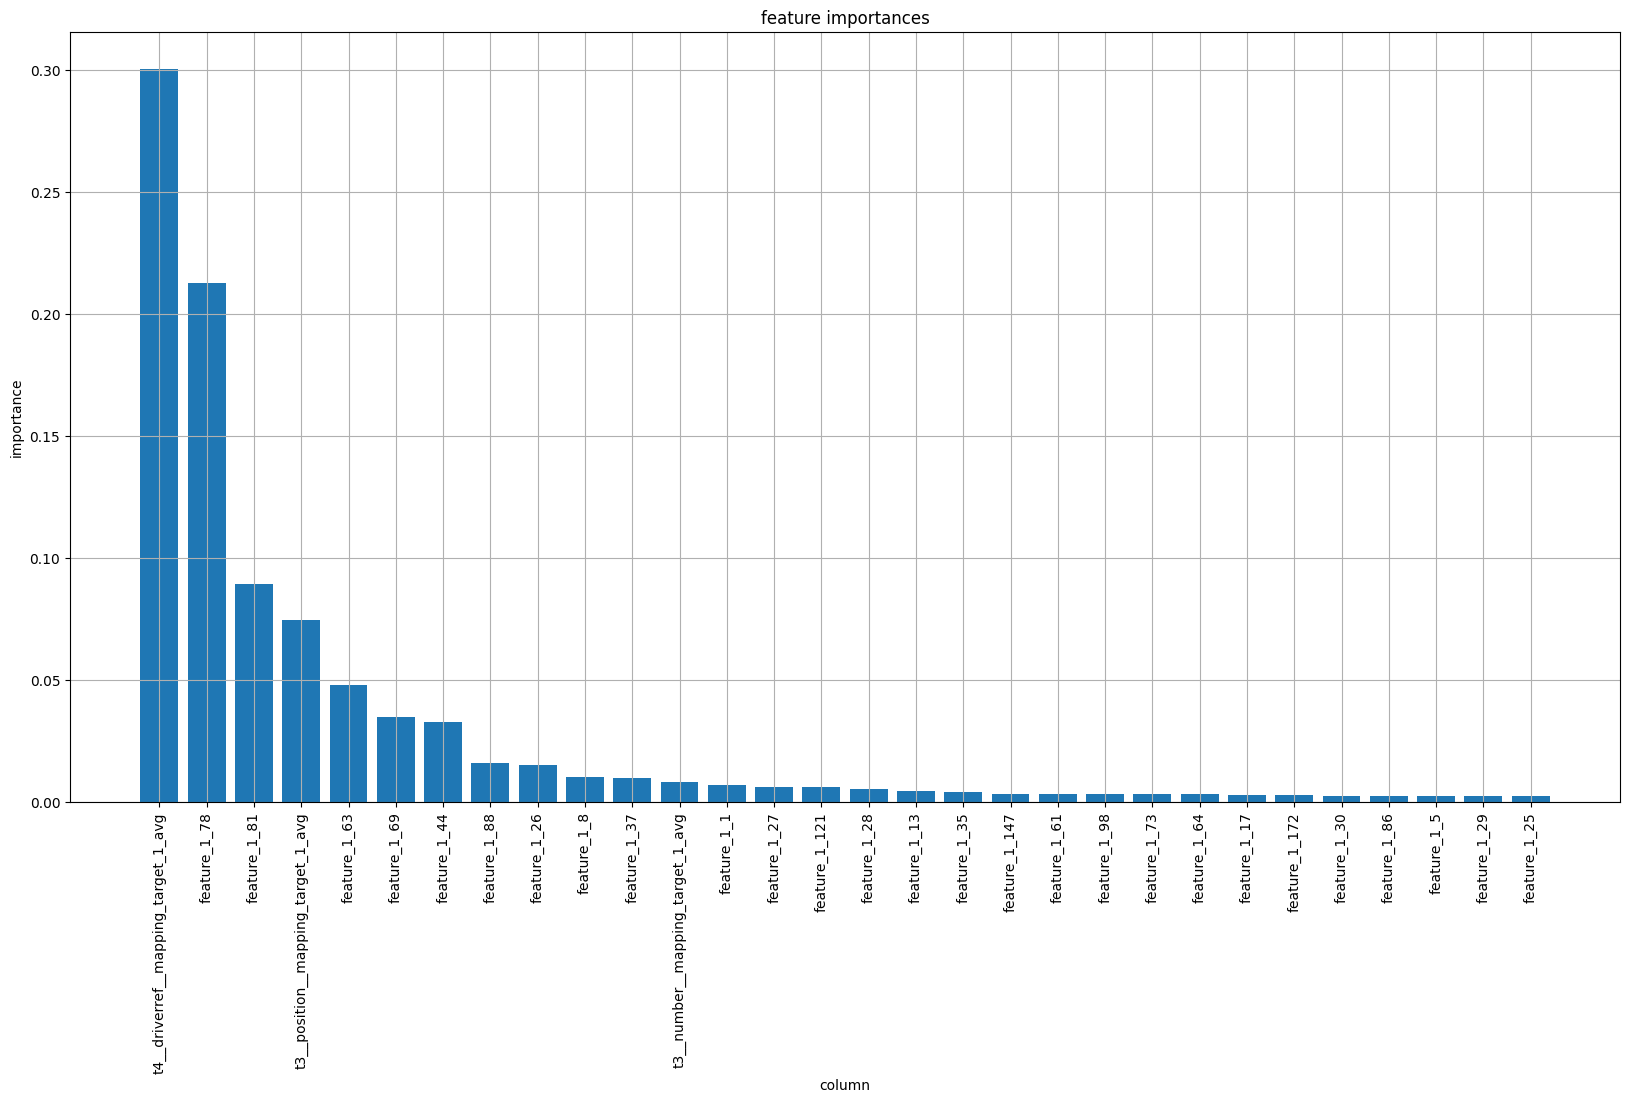

In [287]:
names, importances = pipe1.features.importances(target_num=0)

plt.subplots(figsize=(20, 10))

plt.bar(names[:30], importances[:30])

plt.title("feature importances")
plt.grid(True)
plt.xlabel("column")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

We take a look at the most important features, to get an idea where the predictive power comes from:

In [288]:
pipe1.features.to_sql().find(names[0])[0]

```sql
DROP TABLE IF EXISTS "T4__DRIVERREF__MAPPING_TARGET_1_AVG";

CREATE TABLE "T4__DRIVERREF__MAPPING_TARGET_1_AVG"("key" TEXT, "value" REAL);

INSERT INTO "T4__DRIVERREF__MAPPING_TARGET_1_AVG" ("key", "value")
VALUES('fangio', 0.3653846153846154),
      ('ascari', 0.3055555555555556),
      ('michael_schumacher', 0.3032786885245902),
      ('hamilton', 0.2981366459627329),
      ('stewart', 0.2948717948717949),
      ('prost', 0.264367816091954),
      ('vettel', 0.2467532467532468),
      ('clark', 0.2394366197183098),
      ('senna', 0.2323943661971831),
      ('damon_hill', 0.2159090909090909),
      ('moss', 0.1866666666666667),
      ('mansell', 0.1569767441860465),
      ('lauda', 0.1390728476821192),
      ('alonso', 0.1282051282051282),
      ('hakkinen', 0.1278195488721804),
      ('rosberg', 0.10625),
      ('hunt', 0.1058823529411765),
      ('jack_brabham', 0.1052631578947368),
      ('piquet', 0.09714285714285714),
      ('farina', 0.09523809523809523),
      ('jones', 0.09259259259259259),
      ('brooks', 0.09090909090909091),
      ('scheckter', 0.09),
      ('montoya', 0.08536585365853659),
      ('emerson_fittipaldi', 0.08403361344537816),
      ('rindt', 0.08333333333333333),
      ('hulme', 0.08247422680412371),
      ('peterson', 0.08247422680412371),
      ('reutemann', 0.07936507936507936),
      ('mario_andretti', 0.07142857142857142),
      ('raikkonen', 0.0684931506849315),
      ('villeneuve', 0.06153846153846154),
      ('surtees', 0.0576923076923077),
      ('hill', 0.05194805194805195),
      ('gilles_villeneuve', 0.05),
      ('berger', 0.05),
      ('keke_rosberg', 0.04901960784313725),
      ('hawthorn', 0.04878048780487805),
      ('ickx', 0.04878048780487805),
      ('gurney', 0.04819277108433735),
      ('collins', 0.04761904761904762),
      ('arnoux', 0.04697986577181208),
      ('massa', 0.04587155963302753),
      ('button', 0.04511278195488722),
      ('pironi', 0.04347826086956522),
      ('coulthard', 0.0427807486631016),
      ('revson', 0.0425531914893617),
      ('ricciardo', 0.0425531914893617),
      ('webber', 0.04216867469879518),
      ('ralf_schumacher', 0.03846153846153846),
      ('barrichello', 0.036),
      ('phil_hill', 0.03448275862068965),
      ('rodriguez', 0.03333333333333333),
      ('scarfiotti', 0.03333333333333333),
      ('laffite', 0.03311258278145696),
      ('regazzoni', 0.03225806451612903),
      ('jabouille', 0.03076923076923077),
      ('baghetti', 0.02941176470588235),
      ('flaherty', 0.02941176470588235),
      ('watson', 0.02898550724637681),
      ('mclaren', 0.02803738317757009),
      ('gethin', 0.02777777777777778),
      ('musso', 0.02702702702702703),
      ('cevert', 0.02631578947368421),
      ('ruttman', 0.025),
      ('irvine', 0.025),
      ('max_verstappen', 0.02380952380952381),
      ('hanks', 0.02325581395348837),
      ('alboreto', 0.02298850574712644),
      ('boutsen', 0.02290076335877863),
      ('herbert', 0.02222222222222222),
      ('parsons', 0.02083333333333333),
      ('bryan', 0.02040816326530612),
      ('trintignant', 0.02),
      ('kubica', 0.0196078431372549),
      ('patrese', 0.01951219512195122),
      ('rathmann', 0.01923076923076923),
      ('bandini', 0.01851851851851852),
      ('tambay', 0.01834862385321101),
      ('ginther', 0.01639344262295082),
      ('fisichella', 0.01621621621621622),
      ('ward', 0.01612903225806452),
      ('frentzen', 0.01574803149606299),
      ('brambilla', 0.01492537313432836),
      ('bottas', 0.01470588235294118),
      ('pace', 0.0136986301369863),
      ('maldonado', 0.01298701298701299),
      ('beltoise', 0.01282051282051282),
      ('siffert', 0.01265822784810127),
      ('depailler', 0.0108695652173913),
      ('angelis', 0.0108695652173913),
      ('bonnier', 0.009009009009009009),
      ('mass', 0.008771929824561403),
      ('panis', 0.007692307692307693),
      ('darter', 0),
      ('pretorius', 0),
      ('adamich', 0),
      ('trevor_taylor', 0),
      ('love', 0),
      ('anderson', 0),
      ('bianchi', 0),
      ('courage', 0),
      ('tingle', 0),
      ('attwood', 0),
      ('spence', 0),
      ('resta', 0),
      ('chiron', 0),
      ('reece', 0),
      ('linden', 0),
      ('agabashian', 0),
      ('manzon', 0),
      ('rosier', 0),
      ('villoresi', 0),
      ('graffenried', 0),
      ('hulkenberg', 0),
      ('petrov', 0),
      ('bruno_senna', 0),
      ('daywalt', 0),
      ('perez', 0),
      ('vergne', 0),
      ('pic', 0),
      ('chilton', 0),
      ('gutierrez', 0),
      ('jules_bianchi', 0),
      ('kevin_magnussen', 0),
      ('kvyat', 0),
      ('ericsson', 0),
      ('nasr', 0),
      ('sainz', 0),
      ('schell', 0),
      ('maggs', 0),
      ('gregory', 0),
      ('andre_pilette', 0),
      ('beaufort', 0),
      ('burgess', 0),
      ('salvadori', 0),
      ('trips', 0),
      ('herrmann', 0),
      ('scarlatti', 0),
      ('menditeguy', 0),
      ('gonzalez', 0),
      ('ireland', 0),
      ('thomson', 0),
      ('johnson', 0),
      ('ertl', 0),
      ('hartley', 0),
      ('stevenson', 0),
      ('freeland', 0),
      ('bettenhausen', 0),
      ('boyd', 0),
      ('gould', 0),
      ('behra', 0),
      ('paul_russo', 0),
      ('martini', 0),
      ('larini', 0),
      ('katayama', 0),
      ('morbidelli', 0),
      ('lamy', 0),
      ('brundle', 0),
      ('montermini', 0),
      ('blundell', 0),
      ('suzuki', 0),
      ('moreno', 0),
      ('wendlinger', 0),
      ('gachot', 0),
      ('magnussen', 0),
      ('tarquini', 0),
      ('comas', 0),
      ('bernard', 0),
      ('fittipaldi', 0),
      ('lehto', 0),
      ('cesaris', 0),
      ('alliot', 0),
      ('dalmas', 0),
      ('warwick', 0),
      ('capelli', 0),
      ('gugelmin', 0),
      ('rosa', 0),
      ('heidfeld', 0),
      ('kovalainen', 0),
      ('glock', 0),
      ('sato', 0),
      ('trulli', 0),
      ('sutil', 0),
      ('liuzzi', 0),
      ('wurz', 0),
      ('speed', 0),
      ('albers', 0),
      ('klien', 0),
      ('grouillard', 0),
      ('karthikeyan', 0),
      ('zonta', 0),
      ('gene', 0),
      ('verstappen', 0),
      ('alesi', 0),
      ('salo', 0),
      ('diniz', 0),
      ('buemi', 0),
      ('badoer', 0),
      ('zanardi', 0),
      ('hoffmann', 0),
      ('henton', 0),
      ('daly', 0),
      ('villota', 0),
      ('keegan', 0),
      ('rebaque', 0),
      ('merzario', 0),
      ('stuck', 0),
      ('lunger', 0),
      ('stommelen', 0),
      ('ian_scheckter', 0),
      ('pryce', 0),
      ('jarier', 0),
      ('oliver', 0),
      ('amon', 0),
      ('pescarolo', 0),
      ('wilson_fittipaldi', 0),
      ('keizan', 0),
      ('charlton', 0),
      ('hailwood', 0),
      ('ganley', 0),
      ('redman', 0),
      ('schenken', 0),
      ('palmer', 0),
      ('modena', 0),
      ('caffi', 0),
      ('lammers', 0),
      ('satoru_nakajima', 0),
      ('johansson', 0),
      ('nannini', 0),
      ('schneider', 0),
      ('giacomelli', 0),
      ('alguersuari', 0),
      ('grosjean', 0),
      ('kobayashi', 0),
      ('wisell', 0),
      ('danner', 0),
      ('cheever', 0),
      ('ghinzani', 0),
      ('streiff', 0),
      ('fabi', 0),
      ('surer', 0),
      ('manfred_winkelhock', 0),
      ('baldi', 0),
      ('serra', 0),
      ('salazar', 0);

ALTER TABLE "POPULATION__STAGING_TABLE_1" ADD COLUMN "t4__driverref__mapping_target_1_avg" REAL;

UPDATE "POPULATION__STAGING_TABLE_1" SET "t4__driverref__mapping_target_1_avg" = 0.0;

UPDATE "POPULATION__STAGING_TABLE_1"
SET "t4__driverref__mapping_target_1_avg" = "T4__DRIVERREF__MAPPING_TARGET_1_AVG"."value"
FROM "T4__DRIVERREF__MAPPING_TARGET_1_AVG"
WHERE "POPULATION__STAGING_TABLE_1"."t4__driverref" = "T4__DRIVERREF__MAPPING_TARGET_1_AVG"."key";

DROP TABLE IF EXISTS "T4__DRIVERREF__MAPPING_TARGET_1_AVG";
```

In [289]:
pipe1.features.to_sql()[names[1]]

```sql
DROP TABLE IF EXISTS "FEATURE_1_78";

CREATE TABLE "FEATURE_1_78" AS
SELECT EWMA_90D( t2."win", t1."date" - t2."date__1_000000_days" ) AS "feature_1_78",
       t1.rowid AS rownum
FROM "POPULATION__STAGING_TABLE_1" t1
INNER JOIN "DRIVER_STANDINGS__STAGING_TABLE_2" t2
ON t1."driverid" = t2."driverid"
WHERE t2."date__1_000000_days" <= t1."date"
GROUP BY t1.rowid;
```

In [290]:
pipe1.features.to_sql()[names[2]]

```sql
DROP TABLE IF EXISTS "FEATURE_1_81";

CREATE TABLE "FEATURE_1_81" AS
SELECT EWMA_365D( t2."win", t1."date" - t2."date__1_000000_days" ) AS "feature_1_81",
       t1.rowid AS rownum
FROM "POPULATION__STAGING_TABLE_1" t1
INNER JOIN "DRIVER_STANDINGS__STAGING_TABLE_2" t2
ON t1."driverid" = t2."driverid"
WHERE t2."date__1_000000_days" <= t1."date"
GROUP BY t1.rowid;
```

What we can learn from these features is the following: Knowing which driver we are talking aboyt and who won the most recent races is the best predictor for whether a driver will win this race.

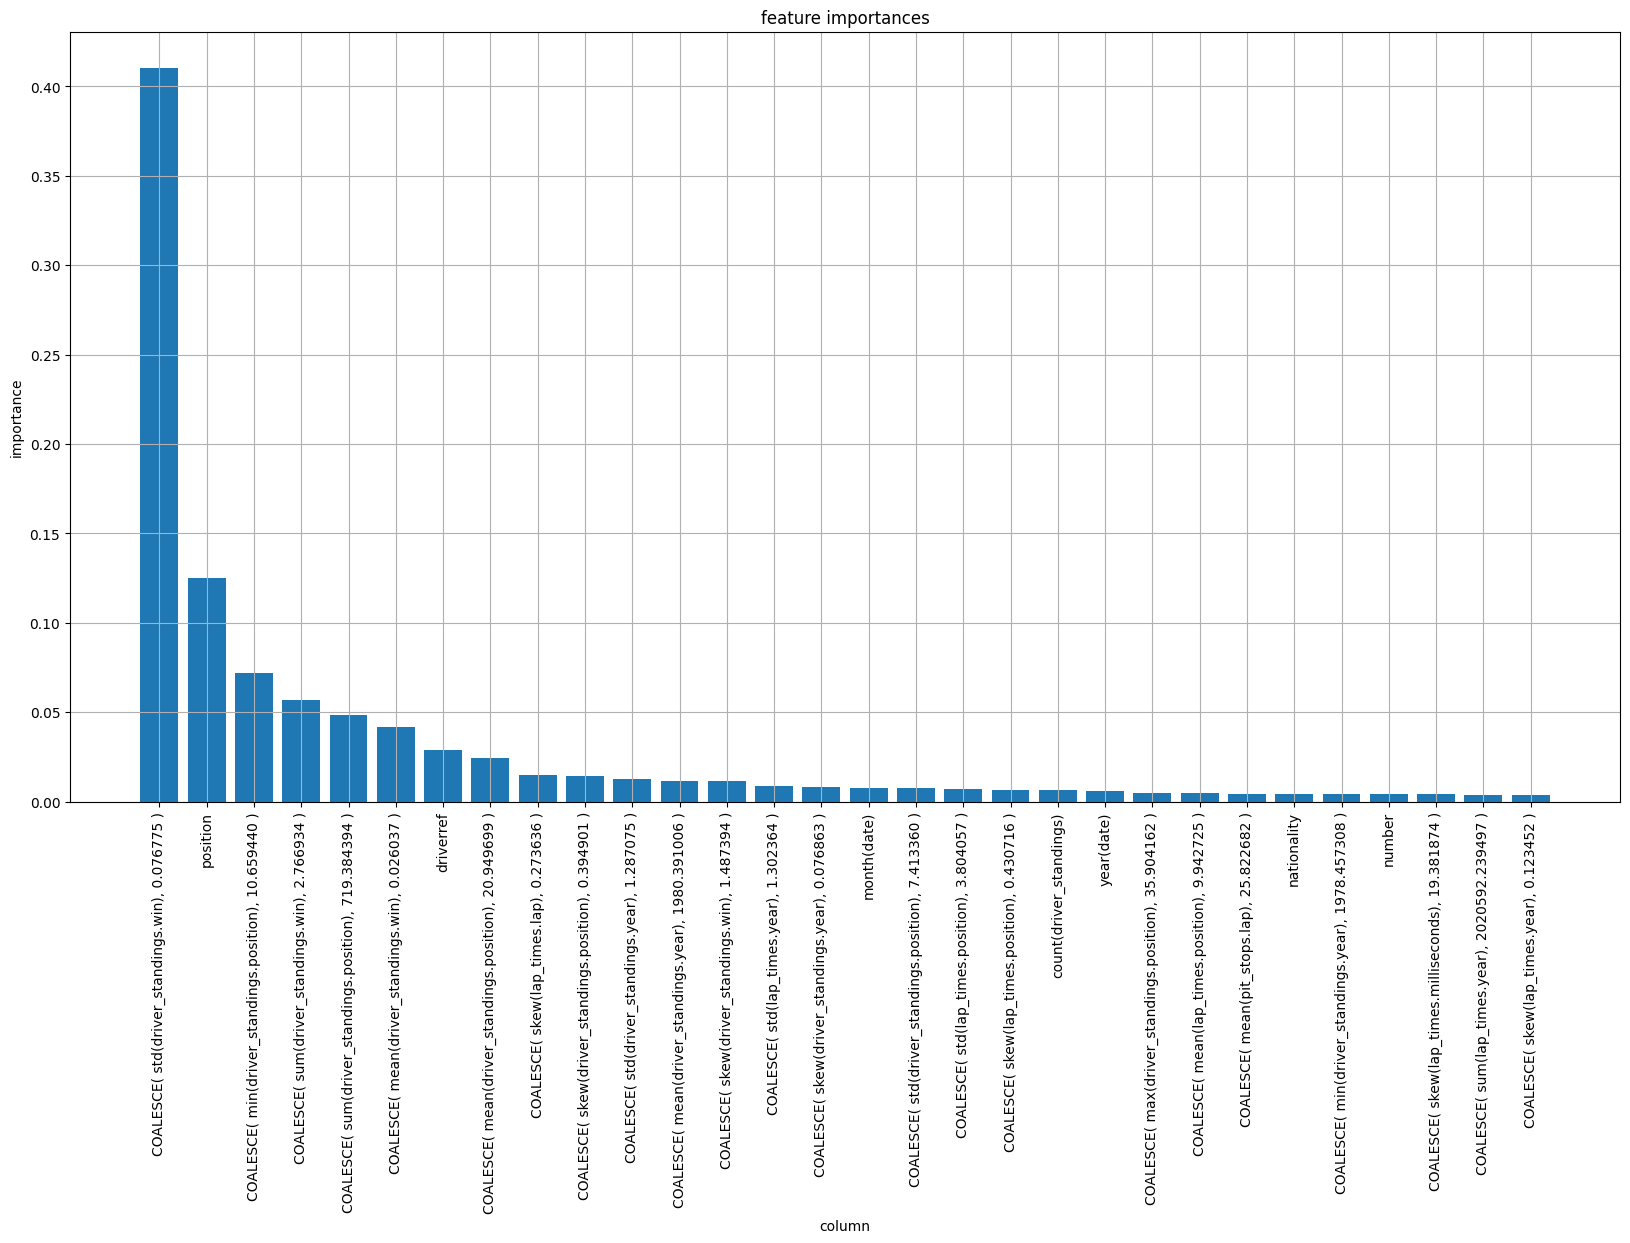

In [291]:
names, importances = pipe2.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names[:30], importances[:30])

plt.title("feature importances")
plt.grid(True)
plt.xlabel("column")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

As we can see, featuretools generally builds features that are similar to the features identified by getML's FastProp.

#### 2.7 Productionization

It is possible to productionize the pipeline by transpiling the features into production-ready SQL code. Please also refer to getML's `sqlite3` and `spark` modules.


In [292]:
# Creates a folder named formula1_pipeline containing
# the SQL code.
pipe1.features.to_sql().save("formula1_pipeline")

In [293]:
pipe1.features.to_sql(dialect=getml.pipeline.dialect.spark_sql).save("formula1_spark")

#### 2.8 Discussion

For a more convenient overview, we summarize our results into a table.

In [294]:
scores = [fastprop_score, featuretools_score]

pd.DataFrame(data={    'Name': ['getML: FastProp', 'featuretools'],
    'Accuracy': [f'{score.accuracy:.2%}' for score in scores],
    'AUC': [f'{score.auc:,.2%}' for score in scores],
    'Cross entropy': [f'{score.cross_entropy:,.5f}' for score in scores]
})

,Name,Accuracy,AUC,Cross entropy
0,getML: FastProp,97.24%,92.35%,0.08533
1,featuretools,97.22%,91.53%,0.08797


As we can see, getML's FastProp outperforms featuretools according to all three measures.

### 3. Conclusion

We have benchmarked getML against featuretools on dataset related to Formula 1 races. We have found that getML's FastProp outperforms featuretools.

## References

Motl, Jan, and Oliver Schulte. "The CTU prague relational learning repository." arXiv preprint arXiv:1511.03086 (2015).